# Access Sentinel 2 Data from AWS

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/opendatacube/odc-stac/develop?labpath=notebooks%2Fstac-load-e84-aws.ipynb)

https://registry.opendata.aws/sentinel-2-l2a-cogs/

In [1]:
import dask.distributed
import folium
import folium.plugins
import geopandas as gpd
import odc.ui
import shapely.geometry
import yaml
from branca.element import Figure
from IPython.display import HTML, display
from odc.algo import to_rgba
from pystac_client import Client

from odc.stac import configure_rio, stac_load

In [2]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [3]:
cfg = """---
sentinel-s2-l2a-cogs:
  assets:
    '*':
      data_type: uint16
      nodata: 0
      unit: '1'
    SCL:
      data_type: uint8
      nodata: 0
      unit: '1'
    visual:
      data_type: uint8
      nodata: 0
      unit: '1'
  aliases:  # Alias -> Canonical Name
    red: B04
    green: B03
    blue: B02
"*":
  warnings: ignore # Disable warnings about duplicate common names
"""
cfg = yaml.load(cfg, Loader=yaml.SafeLoader)

## Start Dask Client

This step is optional, but it does improve load speed significantly. You
don't have to use Dask, as you can load data directly into memory of the
notebook.

In [4]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

<Client: 'tcp://127.0.0.1:40871' processes=1 threads=1, memory=2.00 GiB>

## Find STAC Items to Load

In [5]:
km2deg = 1.0 / 111
x, y = (113.887, -25.843)  # Center point of a query
r = 100 * km2deg
bbox = (x - r, y - r, x + r, y + r)

catalog = Client.open("https://earth-search.aws.element84.com/v0")

query = catalog.search(
    collections=["sentinel-s2-l2a-cogs"], datetime="2021-09-16", limit=100, bbox=bbox
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.get_all_items_as_dict()

Found: 9 datasets


## Review Query Result

We'll use GeoPandas DataFrame object to make plotting easier.

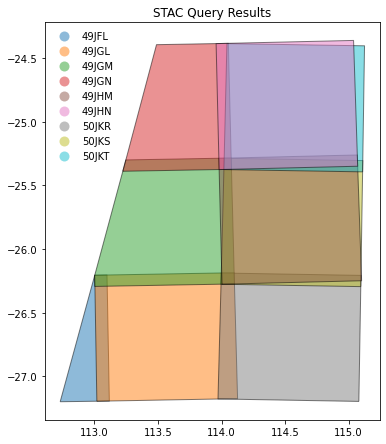

In [6]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
gdf["granule"] = (
    gdf["sentinel:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["sentinel:latitude_band"]
    + gdf["sentinel:grid_square"]
)

fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

## Plot STAC Items on a Map

In [7]:
# https://github.com/python-visualization/folium/issues/1501
fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "sentinel:data_coverage",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

## Construct Dask Dataset

Note that even though there are 9 STAC Items on input, there is only one
timeslice on output. This is because of `groupby="solar_day"`. With that
setting `stac_load` will place all items that occured on the same day (as
adjusted for the timezone) into one image plane.

In [8]:
# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5  # overview level 5

xx = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    stac_cfg=cfg,
)
display(xx)

<xarray.Dataset>
Dimensions:      (time: 1, y: 1098, x: 833)
Coordinates:
  * time         (time) datetime64[ns] 2021-09-16T02:34:44
  * y            (y) float64 -2.797e+06 -2.798e+06 ... -3.148e+06 -3.148e+06
  * x            (x) float64 1.255e+07 1.255e+07 ... 1.282e+07 1.282e+07
    spatial_ref  int32 3857
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1098, 833), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1098, 833), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1098, 833), meta=np.ndarray>
Attributes:
    crs:           epsg:3857
    grid_mapping:  spatial_ref

## Load data and convert to RGBA

In [9]:
%%time
rgba = to_rgba(xx, clamp=(1, 3000))
_rgba = rgba.compute()

CPU times: user 973 ms, sys: 248 ms, total: 1.22 s
Wall time: 22.3 s


## Display Image on a map

In [10]:
map2 = folium.Map()

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map2)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "sentinel:data_coverage",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map2,
)


# Image bounds are specified in Lat/Lon order with Lat axis inversed
image_bounds = convert_bounds(_rgba.geobox.geographic_extent.boundingbox, invert_y=True)
img_ovr = folium.raster_layers.ImageOverlay(
    _rgba.isel(time=0).data, bounds=image_bounds, name="Image"
)
img_ovr.add_to(map2)
map2.fit_bounds(bounds=image_bounds)

folium.LayerControl().add_to(map2)
folium.plugins.Fullscreen().add_to(map2)
map2

## Load with bounding box

As you can see `stac_load` returned all the data covered by STAC items
returned from the query. This happens by default as `stac_load` has no way of
knowing what your query was. But it is possible to control what region is
loaded. There are several mechanisms available, but probably simplest one is
to use `bbox=` parameter (compatible with `stac_client`).

Let's load a small region at native resolution to demonstrate.

In [11]:
r = 6.5 * km2deg
small_bbox = (x - r, y - r, x + r, y + r)

yy = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    stac_cfg=cfg,
    bbox=small_bbox,
)
im_small = to_rgba(yy, clamp=(1, 3000)).compute()

In [12]:
img_zoomed_in = odc.ui.mk_data_uri(
    odc.ui.to_jpeg_data(im_small.isel(time=0).data, quality=80), "image/jpeg"
)
print(f"Image url: {img_zoomed_in[:64]}...")

Image url: data:image/jpeg;base64,/9j/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQOD...



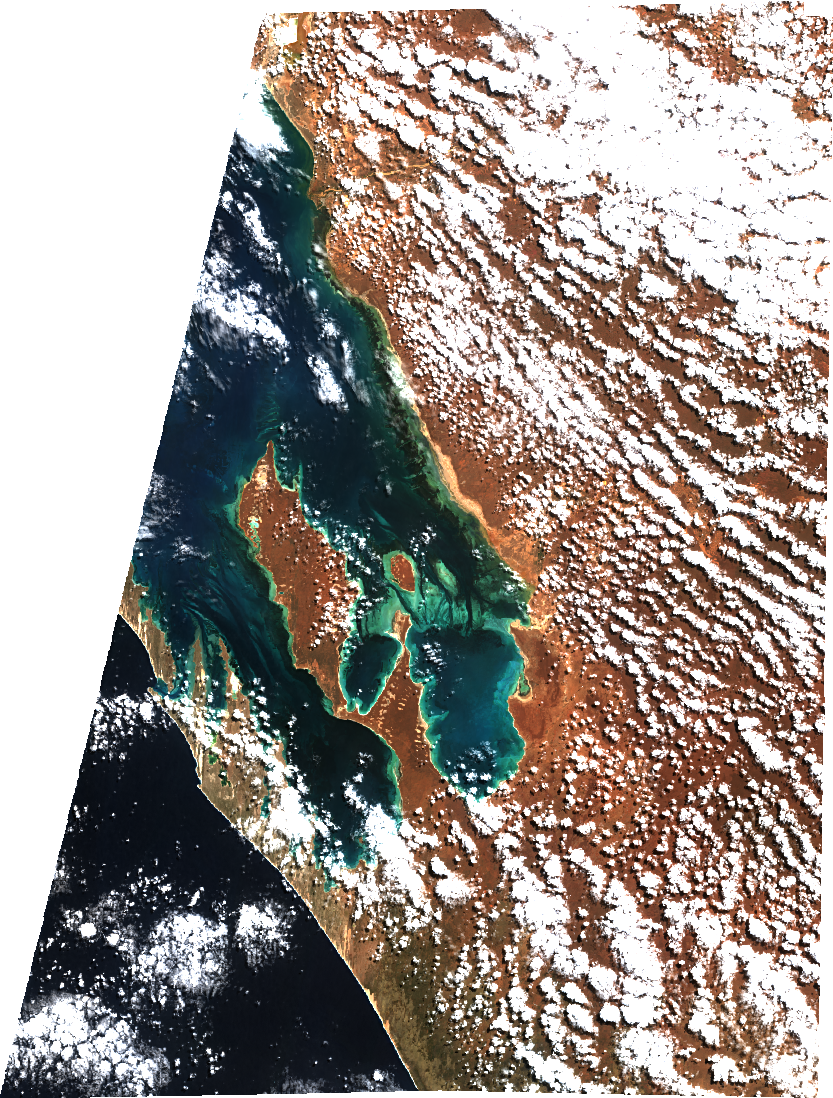

In [13]:
HTML(
    data=f"""
<style> .img-two-column{{
  width: 50%;
  float: left;
}}</style>
<img src="{img_zoomed_in}" alt="Sentinel-2 Zoom in" class="img-two-column">
<img src="{img_ovr.url}" alt="Sentinel-2 Mosaic" class="img-two-column">
"""
)

--------------------------------------------------------------